# Setup

## Installs & Imports

In [1]:
# install libraries not on colab
# %pip install -U --pre efficientnet

In [2]:
import tensorflow as tf
import re
import math
import tensorflow.keras as keras
import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from keras import backend as K
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.train import Feature, Features, Example
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import applications
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import os
import sys
import warnings
import logging
import random

from datetime import datetime
from IPython.display import display 
from io import BytesIO
from PIL import Image
from skimage import io
from typing import List, Tuple

# local vs. colab
IS_LOCAL = False

if IS_LOCAL:
    # jupyter offline
    PATH_KAGGLE_MEL = './../kaggle_symlink_offline/melanoma/'
    REPO_ROOT = './../../'
    REPO_TEMP = REPO_ROOT + 'temp/'
    TFREC_DIR = REPO_ROOT + 'tim/kaggle_symlink_offline/melanoma/tfrecords/triple_stra_{}/'
else:
    # http://tiny.cc/8jjjsz
    # loading from Kaggle to save $$$ (vs. loading from my own GCS)
    KAGGLE_TFREC_GCS ={
        128: 'gs://kds-659708bf9143f303ebfd1c862eb9e842090662d9004190208d007cc9',
        192: 'gs://kds-f53b5775dce9868747163621afd1adc2815412f220130261292837a3',
        256: 'gs://kds-f64cfd42bcb769b2eeeecd53d5a52df83d43c19c1184989ed762e30f',
        384: 'gs://kds-e73569ee9d44308363027e79908294593e80b1e12e18e57ef065397c',
        512: 'gs://kds-4f5e437bc05e29f3e95419fa289ea3a6b01ac2fefcb772ca07cc3b5f',
        768: 'gs://kds-49b793da52a884d00e33c11613f3f24261d8e53e1b8c16de8c868509'}

    # colab online
    PATH_KAGGLE_MEL = '/content/gdrive/My Drive/Kaggle/melanoma/'
    REPO_ROOT = '/content/gdrive/My Drive/melanoma/'
    REPO_TEMP = REPO_ROOT + 'temp/'
    
    # mount google drive only on colab
    from google.colab import drive
    drive.mount('/content/gdrive')

# suppress warning messages
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Model Configurations

In [33]:
if IS_LOCAL: # configr optimize for efficiency due to limited computing power
    # option: TPU, GPU (default to CPU if the specified processor is not found)
    PROCESSOR = "GPU" 

    FOLDS = 2 # option: 3, 5, 15 
    TFREC_SPLITS = 2 # count of tfrec files, hardcoded just for convenience

    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    BATCH_SIZES = [32] * FOLDS 
    EPOCHS = [1] * FOLDS

    # 0: BinaryCrossentropy
    # 1: FocalLoss
    LOSS_FUNCTIONS = [0, 0] 
    LOSS_FUNC_NAMES = ['binary_crossentropy', 'focal_loss']

    EFF_NETS = [0, 4]
    # 128, 192, 256, 384, 512, 768, 1024
    IMG_SIZES = [128, 128]

    TFREC_TRAIN_SETS = [None] * FOLDS
    for i, dim in enumerate(IMG_SIZES):
        TFREC_TRAIN_SETS[i] = tf.io.gfile.glob(TFREC_DIR.format(dim) + 'train*.tfrec')

    # Images used for validation should be subject to the same random augmentation
    # mechanism if input images are randomly augmented. TTA specifies the number of 
    # times each validation image will be randomly augmented and predicted. A final
    # predicted probability is then calculated by averaging.
    TTA_STEPS = 1 # TEST TIME AUGMENTATION STEPS
    RANDOM_AUG = False

else: # configr optimize for performance
    PROCESSOR = "TPU" 

    FOLDS = 5
    TFREC_SPLITS = 15
    
    # dim 512 and bs 128 is the limit of TPU on Colab
    BATCH_SIZES = [32] * FOLDS 
    EPOCHS = [8] * FOLDS

    # 0: BinaryCrossentropy
    # 1: FocalLoss
    LOSS_FUNCTIONS = [0, 1, 0, 1, 1]
    LOSS_FUNC_NAMES = ['binary_crossentropy', 'focal_loss']

    EFF_NETS = [7, 7, 4, 4, 0]
    IMG_SIZES = [256, 256, 256, 256, 512]

    TFREC_TRAIN_SETS = [None] * FOLDS
    for i, dim in enumerate(IMG_SIZES):
        TFREC_TRAIN_SETS[i] = tf.io.gfile.glob(KAGGLE_TFREC_GCS[dim] + '/train*.tfrec')

    TTA_STEPS = 10
    RANDOM_AUG = True

# set true to load the weights from "epoch with the best performance" at the 
# end of training
BEST_MODEL = True 
SIGMOID_THD = 0.2 # used for final prediction
SEED = 207 # used for creating k-fold

## Initializing TPU

In [28]:
if PROCESSOR == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU: ', tpu.master())
    except ValueError:
        print("Error: Unable to connect to TPU...")
        tpu = None

    if tpu:
        try:
            print("Initializing TPU...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized!")
        except _:
            print("Error: Failed to initialize TPU...")
    else:
        PROCESSOR = "GPU"

if PROCESSOR != "TPU":
    print("Using default strategy for CPU/GPU...")
    strategy = tf.distribute.get_strategy()

if PROCESSOR == "GPU":
    print("# of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
            
# https://tinyurl.com/yao4obsb
# A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
# Therefore, for efficient utilization of Cloud TPU, a program should make use of 
# each of the eight cores.
REPLICAS = strategy.num_replicas_in_sync
print(f'# of replicatas in sync: {REPLICAS}')

connecting to TPU...
Running on TPU:  grpc://10.15.3.74:8470
Initializing TPU...


INFO:tensorflow:Initializing the TPU system: grpc://10.15.3.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.15.3.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized!
# of replicatas in sync: 8


## Utility Functions

In [29]:
def read_labeled_tfrecord(example: Example) -> Tuple['tf.string', 'tf.int64']:
    """Extract image & label from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example: Example, 
                            return_img_name: bool) -> Tuple['tf.string', 'tf.int64']:
    """Label is unavailable, extract image & image name from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    if return_img_name:
        return example['image'], example['image_name']
    else:
        return example['image'], 0

def aug_image(img, augment=True, dim=256):
    """Apply random transformation.
    """
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_flip_up_down(img)
        img = tf.clip_by_value(img, 0.0, 1.0)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_examples(file_names: List[str]):
    """Note that the name of each tfrecord file is sufixed with the number of 
    images included.
    """
    n = [int(re.compile(r"-([0-9]*)\.").search(f).group(1)) 
         for f in file_names]
    return np.sum(n)
                  
def get_dataset(tfrec_files: List[str], 
                dim: int,
                batch_size: int = 16,
                augment: bool = False, 
                shuffle: bool = False, 
                repeat: bool = False, 
                labeled: bool = True, 
                return_img_names: bool = True,
                replicas: int = strategy.num_replicas_in_sync) -> Tuple[tf.data.TFRecordDataset, int]:
    """Return a TFRecordDataset by loading tfrecord files.
    Args:
        tfrec_files (List[str]): List of paths to the tfrecord files.
    Returns:
        [0](TFRecordDataset): Two possible column combinations... 
            - 'image' & 'target' for training dataset
            - 'image' & 'image_name' for test dataset
        [1](int): Number of steps to complete an epoch.
    """
    
    AUTO = tf.data.experimental.AUTOTUNE
    ds = tf.data.TFRecordDataset(tfrec_files, 
                                 num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(buffer_size=1024) # 1024 to optimize TPU performance
        opt = tf.data.Options()
        opt.experimental_deterministic = False # ensure a true random shuffle
        ds = ds.with_options(opt)
    
    if labeled: 
        # extract image & label
        # ds inlcudes just one column of examples
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        # extract image & image name
        # ds inlcudes just one column of examples
        map_ = lambda example: read_unlabeled_tfrecord(example, return_img_names)
        ds = ds.map(map_, num_parallel_calls=AUTO)      
    
    # transform image
    # ds has two columns: "image (intf.string)" and "label or image name"
    map_ = lambda img, _: (aug_image(img, augment=augment, dim=dim), _)
    ds = ds.map(map_, num_parallel_calls=AUTO)
    
    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    if PROCESSOR == 'TPU':
        if batch_size < 64:
            # better
            print('Warning: Batch size {} is smaller than 64...'.format(batch_size))
        if batch_size % 8 > 0:
            # min requirement
            print('Error: Batch size {} is not a multiple of 8...'.format(batch_size))
    ds = ds.batch(batch_size) 
    
    num_images = count_examples(tfrec_files)
    steps = num_images // batch_size
    if num_images % batch_size > 0:
        # require one more step to loop through the entire dataset
        steps += 1
    
    # From tf doc (https://tinyurl.com/yavczqkr):
    # Most dataset input pipelines should end with a call to prefetch. This allows 
    # later elements to be prepared while the current element is being processed. This 
    # often improves latency and throughput, at the cost of using additional memory to 
    # store prefetched elements.
    ds = ds.prefetch(AUTO)
    
    return ds, steps

def focal_loss(gamma: float = 2., alpha: float = .25) -> callable:
    """Soruces:
            https://tinyurl.com/y4e66a44
            https://tinyurl.com/yyudyorg
    """
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def build_efns(dim: int, 
               ef: int, 
               loss: int = 0,
               sig_thd: float = SIGMOID_THD) -> Sequential:

    EFNS = [efn.EfficientNetB0, 
            efn.EfficientNetB1, 
            efn.EfficientNetB2, 
            efn.EfficientNetB3, 
            efn.EfficientNetB4, 
            efn.EfficientNetB5, 
            efn.EfficientNetB6]
    LOSS_FS = [tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
               focal_loss()]
    
    m = Sequential()
    base = efn.EfficientNetB7(weights="imagenet", 
                              include_top=False, 
                              input_shape=(dim, dim, 3))
    m.add(base)
    m.add(GlobalAveragePooling2D())
    m.add(Dense(1, activation="sigmoid"))
    
    # compile model; use accuracy to measure model performance
    o = tf.keras.optimizers.Adam(learning_rate=0.001)
    l = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    metrics = [AUC(),
               BinaryAccuracy(threshold=sig_thd),
               Recall(thresholds=SIGMOID_THD),]
    m.compile(optimizer=o, loss=LOSS_FS[loss], metrics=metrics)

    return m

# Test Loading

## TFRecord

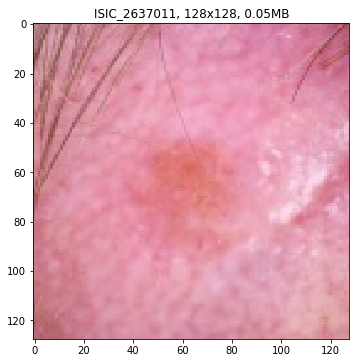

In [ ]:
class TFRECParser:
    """Class to parse the TFRecord files that come with the original dataset.
    """
    __TFREC_DESCRIPTOR = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    } 

    def __init__(self) -> None:
        self.__dataset = None # tf.data.TFRecordDataset

    @tf.autograph.experimental.do_not_convert
    def load(self, path_tfrec: str = 'tfrecords/train*.tfrec') -> None:
        def parser(serialized_example: Example) -> Example:
            example = tf.io.parse_single_example(serialized_example,
                                                 features=TFRECParser.__TFREC_DESCRIPTOR)
            return example
        self.__dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_tfrec))
        self.__dataset = self.__dataset.map(parser)

    def get_dataset(self) -> tf.data.Dataset:
        return self.__dataset

    def get_image_arr(self, image_name: str) -> np.ndarray:
        record_dataset = self.__dataset.filter(lambda example: tf.equal(example["image_name"], image_name))
        example = next(iter(record_dataset))
        arr = tf.image.decode_jpeg(example['image'], channels=3).numpy()
        return arr

    def get_image(self, image_name: str) -> Image:
        return Image.fromarray(self.get_image_arr(image_name))

    def plot_image(self, image_name: str, figsize: list = [5, 5]) -> Image:
        img_arr = self.get_image_arr(image_name)
        img = Image.fromarray(img_arr)

        # prep title
        title = "{}, {}x{}, {:.2f}MB".format(image_name,
                                             img.size[0],
                                             img.size[1],
                                             sys.getsizeof(img_arr)/1024/1024)

        # render plot
        plt.figure(figsize=figsize)
        io.imshow(img_arr)
        plt.title(title)
        plt.show()

# testing: render a smaple image
parser = TFRECParser()
parser.load(TFREC_TRAIN_SETS[0][0])
parser.plot_image('ISIC_2637011')

## Random Transformation

Error: Batch size 28 is not a multiple of 8...


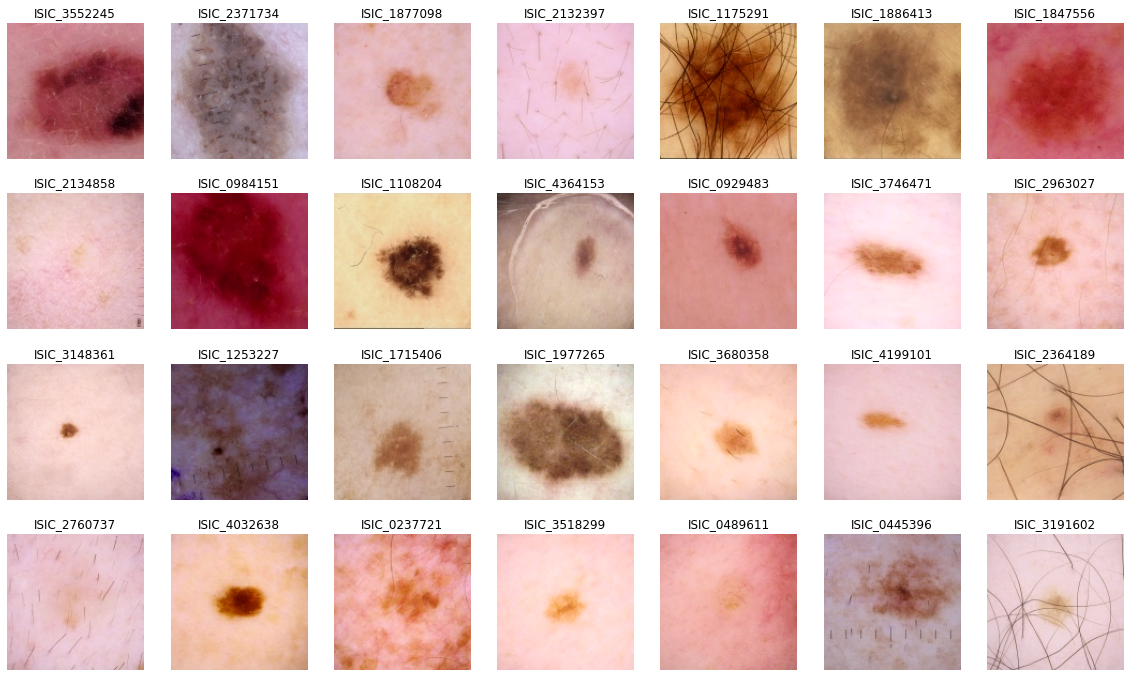

In [8]:
FOLD_TO_TEST = 0
ds, _ = get_dataset(TFREC_TRAIN_SETS[FOLD_TO_TEST], 
                    augment=True, 
                    shuffle=True, 
                    repeat=True,
                    labeled=False,
                    dim=IMG_SIZES[FOLD_TO_TEST], 
                    batch_size=28)

# plot images
fig, axes = plt.subplots(4, 7, figsize=(20, 12))
images, names = next(iter(ds))
images = images.numpy()
i = 0
for row in axes:
    for ax in row:
        img = images[i] * 255
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        
        ax.imshow(img)
        ax.set_title(names[i].numpy().decode("utf-8"))
        ax.axis('off')
        i += 1

# Modeling: K-Fold Cross-Validation

## K-Fold Cross-Validation

In [34]:
SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'

# create folder for saving best models
save_dir = ''
if BEST_MODEL:
    st = datetime.utcnow().strftime('kcv_utc_%m%d_%H%M%S')
    save_dir = SAVE_DIR + st
    os.mkdir(save_dir)
    save_dir += '/'

# lists to save img preds
oof_folds = [] 
oof_pred_proba = []
oof_targets = []
oof_img_names = []
oof_loss_functions = []

# lists to save model info
m_folds = []
m_auc_tta = [] # validation auc with tta
m_auc_no_tta = []
m_sigmoid_thd = []
m_acc = [] # validation accuracy
m_recalls = []
m_loss = []

# build & execute k-folds
skf = KFold(n_splits=FOLDS,
            shuffle=True,
            random_state=SEED)
folds = skf.split(np.arange(TFREC_SPLITS)) 
for fold, (i_train, i_valid) in enumerate(folds):
    # print fold info
    print('')
    print('-' * 50); 
    print('FOLD', fold + 1)
    print('Image Size {}, Batch Size {}, Sigmoid {:.2f}'.format(IMG_SIZES[fold],
                                                                BATCH_SIZES[fold],
                                                                SIGMOID_THD))
    print('EfficientNetB{}, {}'.format(EFF_NETS[fold],
                                       LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]))
    
    # --------------------------------------------------------------------------
    # BUILD DATASETS

    # get train tfrec files
    files = TFREC_TRAIN_SETS[fold]
    files_train = [files[i] for i in i_train]
    np.random.shuffle(files_train)
    files_valid = [files[i] for i in i_valid]
    
    # --------------------------------------------------------------------------
    # BUILD MODEL
    
    # clear current TF graph to prevent memory leak
    keras.backend.clear_session() 
    # use TPU if possible: https://tinyurl.com/y7pkqrat
    with strategy.scope():
        model = build_efns(dim=IMG_SIZES[fold], 
                           ef=EFF_NETS[fold],
                           loss=LOSS_FUNCTIONS[fold])
    
    # save best model
    callbacks = []
    cb = keras.callbacks.ModelCheckpoint(save_dir + 'model_fold_{}.h5'.format(fold), 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=BEST_MODEL,
                                            save_weights_only=True, 
                                            mode='min', 
                                            save_freq='epoch')
    callbacks.append(cb)

    # --------------------------------------------------------------------------
    # TRAINING
    
    print('Training...')
    ds_train, steps_train = get_dataset(files_train, 
                                        augment=RANDOM_AUG, 
                                        shuffle=True, 
                                        repeat=True,
                                        dim=IMG_SIZES[fold], 
                                        batch_size=BATCH_SIZES[fold])
    ds_valid, steps_valid = get_dataset(files_valid,
                                        augment=False,
                                        shuffle=False,
                                        repeat=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold])
    history = model.fit(ds_train, 
                        epochs=EPOCHS[fold], 
                        callbacks=callbacks, 
                        steps_per_epoch=steps_train,
                        validation_data=ds_valid, 
                        #class_weight = {0:1,1:2},
                        verbose=1)

    print('Loading best model...')
    model.load_weights(save_dir + 'model_fold_{}.h5'.format(fold))
    
    # --------------------------------------------------------------------------
    # PREDICTIONS
        
    print('\nPredicting OOF with TTA...')
    # perform TTA
    ds_valid, steps_valid = get_dataset(files_valid,
                                        labeled=False,
                                        return_img_names=False,
                                        augment=RANDOM_AUG,
                                        repeat=True,
                                        shuffle=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold])

    if RANDOM_AUG:
        steps_valid = TTA_STEPS * steps_valid
    preds = model.predict(ds_valid,
                          steps=steps_valid,
                          verbose=1)

    # cut off the "reminders" in the last batch 
    ct_valid = count_examples(files_valid)
    if RANDOM_AUG:
        preds = preds[:TTA_STEPS * ct_valid,] 
    else:
        preds = preds[:ct_valid,] 

    # get oof probabilities; avg pred. proba. over TTAs
    preds_reshape = preds
    if RANDOM_AUG:
        # reshape: each column is one round of prediction
        preds_reshape = preds_reshape.reshape((ct_valid, TTA_STEPS), order='F')
    preds_avg = np.mean(preds_reshape, axis=1)

    # get oof targets
    ds_targets, _ = get_dataset(files_valid, 
                                augment=False, 
                                repeat=False, 
                                labeled=True, 
                                dim=IMG_SIZES[fold])
    targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
    targets = np.array(targets)

    # get oof fold, img names, and loss functions
    ds_img_names, _ = get_dataset(files_valid, 
                                  augment=False, 
                                  repeat=False,
                                  labeled=False, 
                                  return_img_names=True,
                                  dim=IMG_SIZES[fold])
    img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])
    fold_arr = np.zeros_like(targets, dtype='int8') + fold
    loss_arr = np.empty_like(targets, dtype='U')
    loss_func_name = LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]
    loss_arr = np.char.add(loss_arr, loss_func_name)

    # print oof auc
    auc_tta = roc_auc_score(targets, preds_avg)
    auc_no_tta = np.max(history.history['val_auc'][-1])
    print('FOLD {}:'.format(fold + 1))
    print('OOF AUC without TTA =', auc_no_tta)
    print('OOF AUC with TTA =', auc_tta)

    # print report
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= SIGMOID_THD] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print(classification_report(targets, pred_labels))

    # save img-level pred results
    oof_folds.append(fold_arr)
    oof_img_names.append(img_name_arr)
    oof_targets.append(targets)
    oof_pred_proba.append(preds_avg)
    oof_loss_functions.append(loss_arr)

    # save model info
    m_folds.append(fold)
    m_auc_tta.append(auc_tta)
    m_auc_no_tta.append(auc_no_tta)
    m_sigmoid_thd.append(SIGMOID_THD)
    m_acc.append(report['accuracy'])
    m_recalls.append(report['1']['recall'])
    m_loss.append(loss_func_name)


--------------------------------------------------
FOLD 1
Image Size 256, Batch Size 32, Sigmoid 0.20
EfficientNetB7, binary_crossentropy
Training...
Epoch 1/8
818/818 [==============================] - ETA: 0s - recall: 0.0065 - loss: 0.1779 - binary_accuracy: 0.9768 - auc: 0.6287
Epoch 00001: val_loss improved from inf to 0.17206, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0718_093508/best_model_fold_0.h5
818/818 [==============================] - 243s 297ms/step - recall: 0.0065 - loss: 0.1779 - binary_accuracy: 0.9768 - auc: 0.6287 - val_recall: 0.0000e+00 - val_loss: 0.1721 - val_binary_accuracy: 0.9822 - val_auc: 0.7722
Epoch 2/8
818/818 [==============================] - ETA: 0s - recall: 0.0000e+00 - loss: 0.1739 - binary_accuracy: 0.9820 - auc: 0.6613
Epoch 00002: val_loss did not improve from 0.17206
818/818 [==============================] - 217s 266ms/step - recall: 0.0000e+00 - loss: 0.1739 - binary_accuracy: 0.9820 - auc: 0.6613 - va

OSError: ignored

## Testing Sigmoid Thresholds 

In [37]:
THDS = [0.05, 0.2, 0.5]

for thd in THDS:
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= thd] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print("\nSigmoid THD = {:.2f}:".format(thd))
    print(classification_report(targets, pred_labels))


Sigmoid THD = 0.05:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      6411
           1       0.06      0.66      0.12       116

    accuracy                           0.82      6527
   macro avg       0.53      0.75      0.51      6527
weighted avg       0.98      0.82      0.89      6527


Sigmoid THD = 0.20:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6411
           1       0.00      0.00      0.00       116

    accuracy                           0.98      6527
   macro avg       0.49      0.50      0.50      6527
weighted avg       0.96      0.98      0.97      6527


Sigmoid THD = 0.50:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6411
           1       0.00      0.00      0.00       116

    accuracy                           0.98      6527
   macro avg       0.49      0.50      0.50      6527
weighted av

## Saving K-Fold Cross-Validation Results

In [ ]:
SAVE_DIR_OOF = save_dir
SAVE_DIR_MODEL = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'

preds = np.concatenate(oof_pred_proba) 
targets = np.concatenate(oof_targets)
names = np.concatenate(oof_img_names)
folds = np.concatenate(oof_folds)
loss = np.concatenate(oof_loss_functions)

auc = roc_auc_score(targets, preds)
print('Overall OOF AUC with TTA = %.3f'%auc)

# save oof results
df_oof = pd.DataFrame(dict(image=names, 
                           target=targets, 
                           prediction=preds, 
                           fold=folds,
                           loss_function=loss))
df_oof.to_csv(SAVE_DIR_OOF + 'oof.csv', index=False)
print('\nOOF:')
display(df_oof.head())

# save models
df_models = pd.DataFrame(dict(fold=m_folds,
                              auc_tta=m_auc_tta,
                              auc_no_tta=m_auc_no_tta,
                              sigmoid_thd=m_sigmoid_thd,
                              accuracy=m_acc,
                              recalls=m_recalls,
                              loss_function=m_loss))
df_models.to_csv(SAVE_DIR_OOF + 'best_models.csv', index=False)
print('\nBest Models:')
display(df_models)

# append model info to global log
st = datetime.utcnow().strftime('utc_%m%d_%H%M%S')
df_models = pd.DataFrame(dict(fold=m_folds,
                              auc_tta=m_auc_tta,
                              auc_no_tta=m_auc_no_tta,
                              sigmoid_thd=m_sigmoid_thd,
                              accuracy=m_acc,
                              recalls=m_recalls,
                              loss_function=m_loss,
                              save_time=st))

global_model_log = SAVE_DIR_MODEL + 'best_models.csv'
include_header = not os.path.isfile(global_model_log)
df_models.to_csv(global_model_log, 
                 index=False, 
                 mode='a',
                 header=include_header)

# Predicting Test Dataset for Submission

## Full-Dataset Model Training

In [14]:
BATCH_SIZE = 64
EPOCH = 8
IMG_SIZE = 256 # 128, 192, 256, 384, 512, 768, 1024

LOSS_FUNC = 1
EFF_NET = 4

RANDOM_AUG = True
SIGMOID_THD = 0.2

SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'
TFREC_TRAIN_SET = tf.io.gfile.glob(KAGGLE_TFREC_GCS[IMG_SIZE] + '/train*.tfrec')

# --------------------------------------------------------------------------
# BUILD MODEL

print('Building model...')
keras.backend.clear_session() 
with strategy.scope():
    model = build_efns(dim=IMG_SIZE, 
                       ef=EFF_NET,
                       loss=LOSS_FUNC)

# create save dir
st = datetime.utcnow().strftime('fm_utc_%m%d_%H%M%S')
save_dir = SAVE_DIR + st
os.mkdir(save_dir)
save_dir += '/'

# create checkpoints
cb = keras.callbacks.ModelCheckpoint(save_dir + 'last_model.h5', 
                                     verbose=1, 
                                     save_best_only=False,
                                     save_weights_only=False, 
                                     save_freq='epoch')
callbacks = [cb]
        
# --------------------------------------------------------------------------
# TRAINING

print('Training...')
ds_train, steps_train = get_dataset(TFREC_TRAIN_SET, 
                                    augment=RANDOM_AUG, 
                                    shuffle=True, 
                                    repeat=True,
                                    dim=IMG_SIZE, 
                                    batch_size=BATCH_SIZE)
history = model.fit(ds_train, 
                    epochs=EPOCH, 
                    callbacks=callbacks, 
                    steps_per_epoch=steps_train,
                    verbose=1)

Building model...
Training...
Epoch 1/8
511/511 [==============================] - ETA: 0s - recall: 0.1897 - loss: 0.0095 - binary_accuracy: 0.9190 - auc: 0.6945
Epoch 00001: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fm_utc_0718_083004/last_model.h5
511/511 [==============================] - 157s 306ms/step - recall: 0.1897 - loss: 0.0095 - binary_accuracy: 0.9190 - auc: 0.6945
Epoch 2/8
511/511 [==============================] - ETA: 0s - recall: 0.2806 - loss: 0.0077 - binary_accuracy: 0.9281 - auc: 0.7979
Epoch 00002: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fm_utc_0718_083004/last_model.h5
511/511 [==============================] - 159s 311ms/step - recall: 0.2806 - loss: 0.0077 - binary_accuracy: 0.9281 - auc: 0.7979
Epoch 3/8
511/511 [==============================] - ETA: 0s - recall: 0.3052 - loss: 0.0077 - binary_accuracy: 0.9271 - auc: 0.8006
Epoch 00003: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/

## Prediction & Submission

In [26]:
LOAD_MODEL = False

TEST_IMG_DIM = 256 # 128, 192, 256, 384, 512, 768, 1024
TEST_BATCH_SIZE = 1024
TEST_RANDOM_AUG = True
TEST_MODEL = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/fm_utc_0718_075810/model.h5'

SAVE_DIR_SUBMISSION = REPO_ROOT + 'tim/cnn/_saves/submissions/'
if IS_LOCAL:
    TFREC_TEST_SET = tf.io.gfile.glob(TFREC_DIR.format(TEST_IMG_DIM) + 'test*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(KAGGLE_TFREC_GCS[TEST_IMG_DIM] + '/test*.tfrec')

# ------------------------------------------------------------------------------
# PREDICTION

# load model
if LOAD_MODEL:
    print('Loading saved model...')
    keras.backend.clear_session() 
    with strategy.scope():
        model = tf.keras.models.load_model(TEST_MODEL)

# predict test dataset
ds_test, steps = get_dataset(TFREC_TRAIN_SET,
                             labeled=False,
                             return_img_names=False,
                             augment=TEST_RANDOM_AUG,
                             repeat=True,
                             shuffle=False,
                             dim=TEST_IMG_DIM,
                             batch_size=TEST_BATCH_SIZE)
if RANDOM_AUG:
    steps = TTA_STEPS * steps
preds = model.predict(ds_test, steps=steps, verbose=1)

# cut off the "reminders" in the last batch 
ct_test = count_examples(TFREC_TRAIN_SET)
if RANDOM_AUG:
    preds = preds[:TTA_STEPS * ct_test,] 
else:
    preds = preds[:ct_test,] 

# get oof probabilities; avg pred. proba. over TTAs
preds_reshape = preds
if RANDOM_AUG:
    # reshape: each column is one round of prediction
    preds_reshape = preds_reshape.reshape((ct_test, TTA_STEPS), order='F')
preds_avg = np.mean(preds_reshape, axis=1)

# ------------------------------------------------------------------------------
# GET IMAGE NAMES

ds_img_names, steps = get_dataset(TFREC_TRAIN_SET,
                                  labeled=False,
                                  return_img_names=True,
                                  augment=False,
                                  repeat=False,
                                  shuffle=False,
                                  dim=TEST_IMG_DIM)
img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])

# ------------------------------------------------------------------------------
# SAVE TO CSV

submission = pd.DataFrame(dict(image_name=img_name_arr, 
                               target=preds_avg))
submission.sort_values('image_name', inplace= True) 
st = datetime.utcnow().strftime('utc_%m%d_%H%M%S')
submission.to_csv(SAVE_DIR_SUBMISSION + 'submission_' + st + '.csv', index=False)
submission.head()

110/110 [==============================] - 49s 443ms/step


,image_name,target
9905,ISIC_0052060,0.052528
1443,ISIC_0052349,0.032203
3120,ISIC_0058510,0.037248
4870,ISIC_0073313,0.026867
5494,ISIC_0073502,0.084687
